# Module 2 - Introduction to Forecasting with __Python__

## Lectures

### Introduction

In the first lecture, a simple linear model of the type


$log(F_{gdp}) = c + log(A_{gdp})$

is estimated, visualized, and briefly analyzed. Let's see how to do it in Python using `statsmodels`.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from utils_statsmodels import bglm_test, dynamic_pred

In [161]:
df = pd.read_csv("data/Module_2_Fiji_fiji.csv")
df.head()

,Date,RGDP_FIJI,G_REAL_GROWTH_FIJI,RGDP_AUS,G_REAL_GROWTH_AUS,REER_FIJI,SUGAROUTPUT_FIJI,G_SUGAR_OUTPUT,SUGAROUTPUT_FIJI_MISSING
0,1970.0,1.6316,NaN,406.2,NaN,NaN,NaN,NaN,NaN
1,1971.0,1.7436,6.864428,421.7,3.815854,NaN,NaN,NaN,NaN
2,1972.0,1.8744,7.501721,429.7,1.897083,NaN,NaN,NaN,NaN
3,1973.0,2.0921,11.614383,451.4,5.050035,NaN,NaN,NaN,NaN
4,1974.0,2.1453,2.542899,458.0,1.462118,NaN,NaN,NaN,NaN


Let's do some precleaning to keep only `date`, `rgdp_fiji`, and `rgdp_aus`.

In [162]:
df.columns = [x.lower() for x in df.columns]
df = df[["date", "rgdp_fiji", "rgdp_aus"]]
df.head()

,date,rgdp_fiji,rgdp_aus
0,1970.0,1.6316,406.2
1,1971.0,1.7436,421.7
2,1972.0,1.8744,429.7
3,1973.0,2.0921,451.4
4,1974.0,2.1453,458.0


In [164]:
# Transform into logs:
df1 = (df
    .assign(
        log_rgdp_fiji=np.log(df.rgdp_fiji),
        log_rgdp_aus=np.log(df.rgdp_aus)
    )
    .dropna()
)

In [165]:
X = df1.log_rgdp_aus
X = sm.add_constant(X)
Y = df1.log_rgdp_fiji
model = sm.OLS(Y, X)
results = model.fit()
results.summary()

/home/joao/moocs/time-series/envs/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_rgdp_fiji   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1867.
Date:                Thu, 14 Oct 2021   Prob (F-statistic):           1.92e-36
Time:                        14:48:32   Log-Likelihood:                 70.269
No. Observations:                  44   AIC:                            -136.5
Df Residuals:                      42   BIC:                            -133.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -4.1952      0.124    -33.878      0.000      -4.445      -3.945
log_rgdp_aus     0.8010      0.019     43.208      0.000       0.764       0.838
==============================================================================
Omnibus:                        4.947   Durbin-Watson:                   0.687
Prob(Omnibus):                  0.084   Jarque-Bera (JB):                4.232
Skew:                          -0.758   Prob(JB):                        0.121
Kurtosis:                       3.105   Cond. No.                         112.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

To finish with the introduction, let's plot the dependent variable, the predicted values, and the residuals:

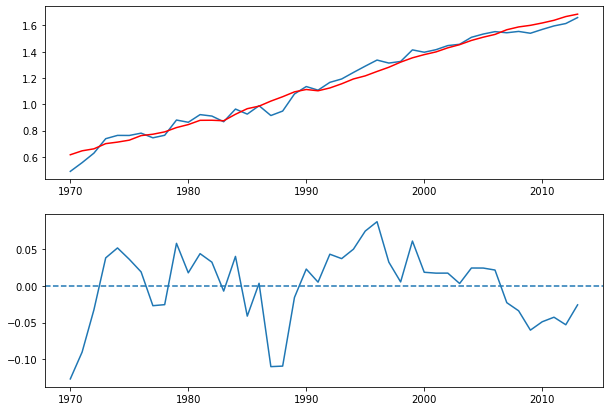

In [166]:
fig, ax = plt.subplots(2, figsize=(10, 7))

ax[0].plot(df1.date, Y)
ax[0].plot(df1.date, results.predict(), color="r");

ax[1].plot(df1.date, results.resid)
ax[1].axhline(0, ls='--');


## Session 3: Equation Object: Allowing for Additional Variables, Including Dynamics

In this session, we add additional variables and lags to the model presented in the introduction.

First, we add sugar production and a dummy variable to cover the 2008 crisis period:

$log(F_{gdp}) = c + log(A_{gdp}) + log(F_{sugar}) + GFC_{07-10}$

In [2]:
# Reload csv and make transformations
df = pd.read_csv("data/Module_2_Fiji_fiji.csv", index_col='Date')
df.columns = [x.lower() for x in df.columns]
df = df.loc[:, ["rgdp_fiji", "rgdp_aus", "sugaroutput_fiji"]]
df.head()

,rgdp_fiji,rgdp_aus,sugaroutput_fiji
Date,,,
1970.0,1.6316,406.2,NaN
1971.0,1.7436,421.7,NaN
1972.0,1.8744,429.7,NaN
1973.0,2.0921,451.4,NaN
1974.0,2.1453,458.0,NaN


In [3]:
df = (
    df
    .pipe(lambda x: x.assign(
        # Create a dummy for GFC
        gfc=np.where(x.index.isin([2007, 2008, 2009, 2010]), 1, 0),
        # Create lags
        **{f'lag_{col.name}': col.shift(1) for col in [x.rgdp_fiji, x.rgdp_aus]}
    ))
    .pipe(lambda x: x.assign(
        # Create logs
        **{f'log_{col.name}': np.log(col) for col in [x.rgdp_fiji, x.rgdp_aus, x.sugaroutput_fiji, x.lag_rgdp_fiji, x.lag_rgdp_aus]}
        ))
    .dropna()
)
df.tail(10)

,rgdp_fiji,rgdp_aus,sugaroutput_fiji,gfc,lag_rgdp_fiji,lag_rgdp_aus,log_rgdp_fiji,log_rgdp_aus,log_sugaroutput_fiji,log_lag_rgdp_fiji,log_lag_rgdp_aus
Date,,,,,,,,,,,
2004.0,4.5238,1202.7,3001.0,0,4.2897,1155.4,1.509352,7.092324,8.006701,1.456217,7.052202
2005.0,4.6368,1240.4,2789.0,0,4.5238,1202.7,1.534024,7.123189,7.933438,1.509352,7.092324
2006.0,4.7229,1273.5,3226.0,0,4.6368,1240.4,1.552423,7.149524,8.078998,1.534024,7.123189
2007.0,4.6823,1331.4,2478.0,1,4.7229,1273.5,1.543789,7.193986,7.815207,1.552423,7.149524
2008.0,4.7306,1367.2,2321.0,1,4.6823,1331.4,1.554052,7.220520,7.749753,1.543789,7.193986
2009.0,4.6650,1388.3,2247.0,1,4.7306,1367.2,1.540088,7.235835,7.717351,1.554052,7.220520
2010.0,4.8029,1419.5,1778.0,1,4.6650,1388.3,1.569220,7.258060,7.483244,1.540088,7.235835
2011.0,4.9328,1456.3,2096.0,0,4.8029,1419.5,1.595907,7.283654,7.647786,1.569220,7.258060
2012.0,5.0231,1508.8,1640.0,0,4.9328,1456.3,1.614047,7.319070,7.402452,1.595907,7.283654


In [5]:
# Regress
X = df[["log_rgdp_aus", "log_sugaroutput_fiji", "gfc"]]
X = sm.add_constant(X)
y = df["log_rgdp_fiji"]

model = sm.OLS(y, X)
results = model.fit()
results.summary()

/home/joao/moocs/time-series/envs/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_rgdp_fiji   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     657.5
Date:                Sun, 17 Oct 2021   Prob (F-statistic):           3.82e-20
Time:                        10:59:46   Log-Likelihood:                 65.292
No. Observations:                  24   AIC:                            -122.6
Df Residuals:                      20   BIC:                            -117.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -4.9662      0.328    -15.149      0.000      -5.650      -4.282
log_rgdp_aus             0.7977      0.026     30.225      0.000       0.743       0.853
log_sugaroutput_fiji     0.1015      0.021      4.891      0.000       0.058       0.145
gfc                     -0.0272      0.011     -2.511      0.021      -0.050      -0.005
==============================================================================
Omnibus:                        1.051   Durbin-Watson:                   1.656
Prob(Omnibus):                  0.591   Jarque-Bera (JB):                0.886
Skew:                          -0.211   Prob(JB):                        0.642
Kurtosis:                       2.159   Cond. No.                         985.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

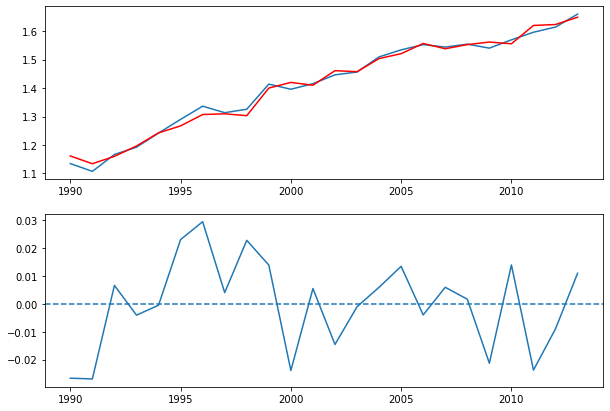

In [6]:
fig, ax = plt.subplots(2, figsize=(10, 7))

ax[0].plot(df.index, y)
ax[0].plot(df.index, results.predict(), color="r");

ax[1].plot(df.index, results.resid)
ax[1].axhline(0, ls='--');

In [7]:
X = df[["log_lag_rgdp_fiji", "log_rgdp_aus", "log_lag_rgdp_aus", "log_sugaroutput_fiji", "gfc"]]
X = sm.add_constant(X)
y = df["log_rgdp_fiji"]

model = sm.OLS(y, X)
results = model.fit()
results.summary()

/home/joao/moocs/time-series/envs/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_rgdp_fiji   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     512.4
Date:                Sun, 17 Oct 2021   Prob (F-statistic):           9.57e-19
Time:                        10:59:52   Log-Likelihood:                 69.657
No. Observations:                  24   AIC:                            -127.3
Df Residuals:                      18   BIC:                            -120.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -4.3060      0.656     -6.562      0.000      -5.685      -2.927
log_lag_rgdp_fiji        0.1075      0.130      0.827      0.419      -0.166       0.381
log_rgdp_aus             1.3950      0.282      4.948      0.000       0.803       1.987
log_lag_rgdp_aus        -0.6950      0.263     -2.640      0.017      -1.248      -0.142
log_sugaroutput_fiji     0.0827      0.021      4.005      0.001       0.039       0.126
gfc                     -0.0231      0.010     -2.398      0.028      -0.043      -0.003
==============================================================================
Omnibus:                        2.449   Durbin-Watson:                   2.324
Prob(Omnibus):                  0.294   Jarque-Bera (JB):                1.256
Skew:                           0.168   Prob(JB):                        0.534
Kurtosis:                       1.931   Cond. No.                     2.75e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.75e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

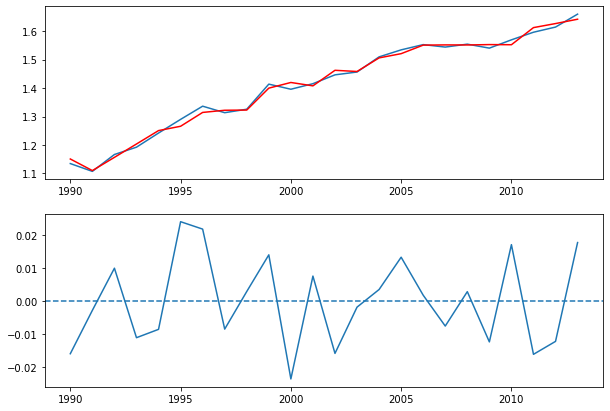

In [8]:
fig, ax = plt.subplots(2, figsize=(10, 7))

ax[0].plot(df.index, y)
ax[0].plot(df.index, results.predict(), color="r");

ax[1].plot(df.index, results.resid)
ax[1].axhline(0, ls='--');

In [9]:
from utils_statsmodels import bglm_test
bglm_test(results, 3)

Breusch-Godfrey LM Test: 
LM test statistic      5.915717
LM (Chi-sq) p-value    0.115784
F test statistic       1.635596
F p-value              0.223290
Null hypothesis: No Autocorrelation of any order up to 3 lags.
Fail to reject the null hypothesis at the .05 significance level
Data has no evidence of autocorrelation.


## Session 4 - Basic Forecasting

In this session we're going to make our first forecasts. 

However, we must first understand the difference between static and dynamic forecasting that are relevant when we use a lag of the dependent variable as a regressor. 

- Static forecast: the observed value in the previous period is used to generate the forecast in the subsequent period.

- Dynamic forecast: the forecast of period t generated in t-1 is used in period t to forecast period t+1.

For the exogenous variables, observed values are always used. This means that in the context of OLS we cannot use exogenous variables that are measured at the same time as the forecasted variable in out-of-sample forecasts.


About the code: `statsmodels` requires you to pass a vector of exogenous variables if you want to forecast out-of-sample. To replicate the forecasts of the lecture, I'm going to split the dataset between a training and a testing dataset, so we can pass the vector of exogenous variables of the testing set to the `.get_predictions()` method. 

To view the results, we call the `.summary_frame()` method on the predictions. The prediction are the `mean` column of this dataframe, while the the `obs_ci_lower` and `obs_ci_upper` are the confidence interval of the forecast that includes uncertainty on the parameters and on the model.

View this link for reference: https://github.com/statsmodels/statsmodels/issues/4437#issuecomment-445466780

In [10]:
train = df.loc[:2011]
test = df.loc[2011:]

In [11]:
# Create train and test X sets
X_train = train[["log_lag_rgdp_fiji", "log_rgdp_aus", "log_lag_rgdp_aus", "log_sugaroutput_fiji", "gfc"]]
X_train = sm.add_constant(X_train)
y_train = train["log_rgdp_fiji"]

X_test = test[["log_lag_rgdp_fiji", "log_rgdp_aus", "log_lag_rgdp_aus", "log_sugaroutput_fiji", "gfc"]]
X_test = sm.add_constant(X_test)

# Static prediction:
results = sm.OLS(y_train, X_train).fit()
predictions = results.get_prediction(X_test)
df_stat_pred = predictions.summary_frame(alpha=0.05)
df_stat_pred


/home/joao/moocs/time-series/envs/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
Date,,,,,,
2011.0,1.609140,0.010065,1.587803,1.630478,1.570356,1.647925
2012.0,1.623932,0.012349,1.597754,1.650111,1.582287,1.665577
2013.0,1.638234,0.011753,1.613318,1.663150,1.597371,1.679097


In [26]:
df_dyn_pred = dynamic_pred(results, X_test, "log_lag_rgdp_fiji")
df_dyn_pred


,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
Date,,,,,,
2011.0,1.609140,0.010065,1.587803,1.630478,1.570356,1.647925
2012.0,1.625515,0.012060,1.599949,1.651081,1.584252,1.666778
2013.0,1.639606,0.011435,1.615364,1.663847,1.599150,1.680061


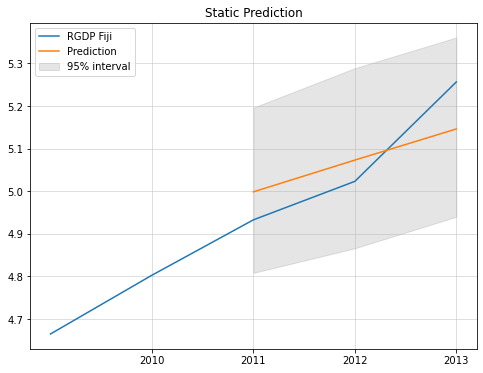

In [27]:
from matplotlib.dates import DateFormatter
# Plot the results:

fig, ax = plt.subplots(figsize=(8, 6))

ax.set_title("Static Prediction")

df_ = df_stat_pred[["mean", "obs_ci_lower", "obs_ci_upper"]].apply(np.exp)

ax.plot(df.loc[2009:, ['rgdp_fiji']], label="RGDP Fiji")
ax.plot(df_[["mean"]], label = "Prediction")
ax.fill_between(df_.index, df_['obs_ci_lower'], df_['obs_ci_upper'], color='k', alpha=0.1, label='95% interval')
ax.legend(loc='upper left')

#date_form = DateFormatter("%Y")
#ax.xaxis.set_major_formatter(date_form)

ax.set_xticks([2010, 2011, 2012, 2013])
ax.grid(which='major', alpha=0.5);

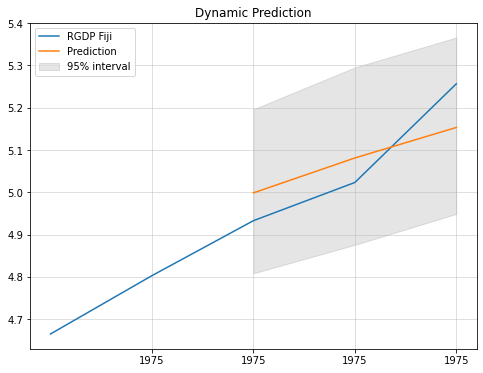

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.set_title("Dynamic Prediction")

df_ = df_dyn_pred[["mean", "obs_ci_lower", "obs_ci_upper"]].apply(np.exp)

ax.plot(df.loc[2009:, ['rgdp_fiji']], label="RGDP Fiji")
ax.plot(df_['mean'], label = "Prediction")
ax.fill_between(df_.index, df_['obs_ci_lower'], df_['obs_ci_upper'], color='k', alpha=0.1, label='95% interval')
ax.legend(loc='upper left')

date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)

ax.set_xticks([2010, 2011, 2012, 2013])
ax.grid(which='major', alpha=0.5);

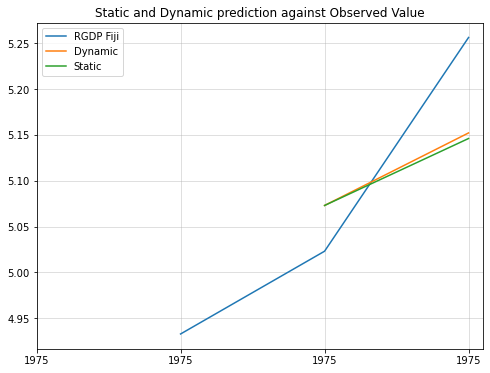

In [34]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.set_title("Static and Dynamic prediction against Observed Value")

ax.plot(df.loc[2011:, ['rgdp_fiji']], label="RGDP Fiji")
ax.plot(df_dyn_pred[["mean"]].apply(np.exp), label = "Dynamic")
ax.plot(df_stat_pred[["mean"]].apply(np.exp), label = "Static")
ax.legend()

date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)

ax.set_xticks([2010, 2011, 2012, 2013])
ax.grid(which='major', alpha=0.5);

## Session 5

I'll remake the predictions because in this lecture they predict only 2012 and 2013 and I want to have exactly the same values.

In [38]:
# Prediction:
results = sm.OLS(train['log_rgdp_fiji'], X_train).fit()
predictions = results.get_prediction(X_test[2012:])
df_stat_pred = predictions.summary_frame(alpha=0.05)
df_stat_pred
df_dyn_pred = dynamic_pred(results, X_test[2012:], "log_lag_rgdp_fiji")
df_dyn_pred


# Compare with Session 4, Part 2 video at 10:10 to check that values match precisely.
df_preds = pd.DataFrame({
    'observed': test.loc[2012:, 'rgdp_fiji'].values,
    "static": df_stat_pred['mean'].values,
    'dynamic': df_dyn_pred['mean'].values,}).set_index(df_stat_pred.index)

(
    df_preds
    .pipe(lambda x: x.assign(
        **{f'{col.name}': np.exp(col) for col in [x.static, x.dynamic]}
    ))
)

,observed,static,dynamic
Date,,,
2012.0,5.0231,5.073000,5.073000
2013.0,5.2563,5.146074,5.152161


Here, they use the model solvers in EViews to calculate a stochastic forecast based on bootstrapping the residuals. Since it is not clear what EViews is making when it calls bootstrapping methods, I'm going to use the method of bootstrapped residuals (as explained in section 4.3 here: http://time-series.net/yahoo_site_admin/assets/docs/SupplementaryManual_all.117125921.pdf). Since our Breusch-Godfrey statistic indicates no evidence of autocorrelation in the residuals, it is ok to do the simplest method.

I'm using the `stochastic_forecast()` function defined in `utils_statsmodels`. Note that my bootstrapping technique is more confident than EViews (probably because I didn't incorporate coefficient uncertainty). If I bootstrap the residuals but take use `statsmodels` to get the predictions incorporating coefficient uncertainty, then the model becomes more conservative than EViews. That's also a significant performance loss, with the alternative stochastic forecast function `stochastic_forecast2()` taking 13 seconds to bootstrap 10000 obs while `stochastic_forecast()` takes only 2 seconds.

In [39]:
from utils_statsmodels import stochastic_forecast, stochastic_forecast2

dfb = stochastic_forecast2(results, X_train, X_test[2012:], ci=.1, simulations=1000)
dfb_levels = dfb.apply(np.exp)
dfb_levels

,mean,lower,upper
Date,,,
2012.0,5.071104,4.925632,5.220873
2013.0,5.144671,4.999820,5.293718


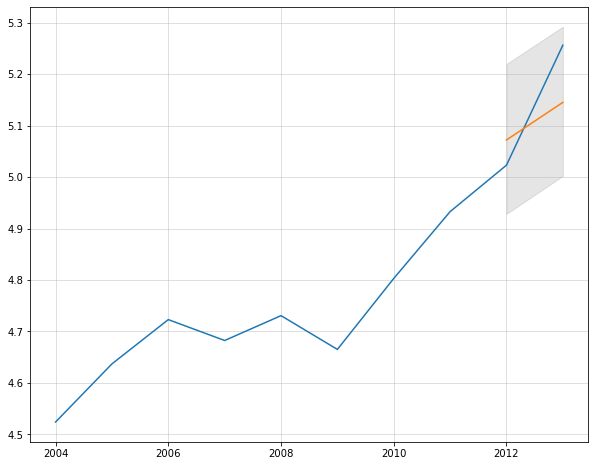

In [65]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(df["rgdp_fiji"][2004:])

ax.plot(dfb_levels['mean'])

ax.fill_between(dfb.index, dfb_levels['lower'], dfb_levels['upper'], color='k', alpha=0.1)

ax.grid(which='major', alpha=0.5);

To finish this session, they present an alternative scenario where sugaroutput would be 10% higher in 2011 and 2012. That's actually quite simple to implement with Python and Pandas.

First, we create a new variable called `log_sugaroutput_fiji1`, and then we estimate a new model.

In [227]:
df = (df
     .assign(log_sugaroutput_fiji1=lambda x: np.where(
         x.index.isin([2011, 2012]), 
         np.log(x.sugaroutput_fiji * 1.1),
         x.log_sugaroutput_fiji
     )))

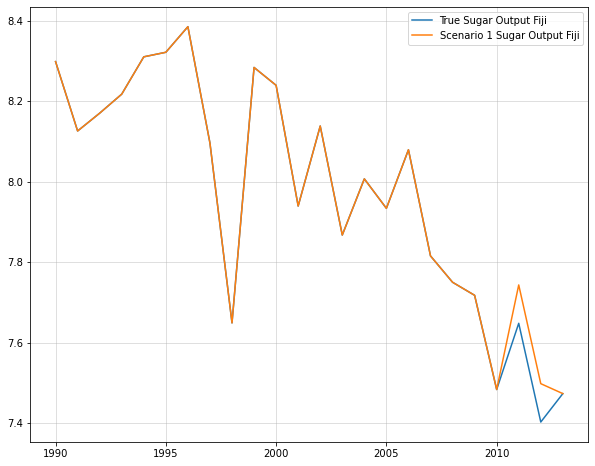

In [229]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(df['log_sugaroutput_fiji'], label="True Sugar Output Fiji")
ax.plot(df['log_sugaroutput_fiji1'], label="Scenario 1 Sugar Output Fiji")

ax.legend()

#ax.fill_between(dfb.index, dfb_levels['lower'], dfb_levels['upper'], color='k', alpha=0.1)

ax.grid(which='major', alpha=0.5);

In [224]:
# Prediction:
X_train_sc1 = df.loc[:2011, ['log_rgdp_aus', 'log_lag_rgdp_aus', 'log_lag_rgdp_fiji', 'log_sugaroutput_fiji1', 'gfc']]
X_train_sc1 = sm.add_constant(X_train_sc1)
X_test_sc1 = df.loc[2012:, ['log_rgdp_aus', 'log_lag_rgdp_aus', 'log_lag_rgdp_fiji', 'log_sugaroutput_fiji1', 'gfc']]
X_test_sc1 = sm.add_constant(X_test_sc1)
results_sc1 = sm.OLS(train['log_rgdp_fiji'], X_train_sc1).fit()
predictions_sc1 = results_sc1.get_prediction(X_test_sc1[2012:])
df_stat_pred_sc1 = predictions_sc1.summary_frame(alpha=0.05)
df_stat_pred_sc1
df_dyn_pred_sc1 = dynamic_pred(results_sc1, X_test_sc1[2012:], "log_lag_rgdp_fiji")
df_dyn_pred_sc1

/home/joao/moocs/time-series/envs/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
Date,,,,,,
2012.0,1.618853,0.013146,1.590986,1.646721,1.576171,1.661535
2013.0,1.633760,0.012193,1.607912,1.659608,1.592368,1.675152


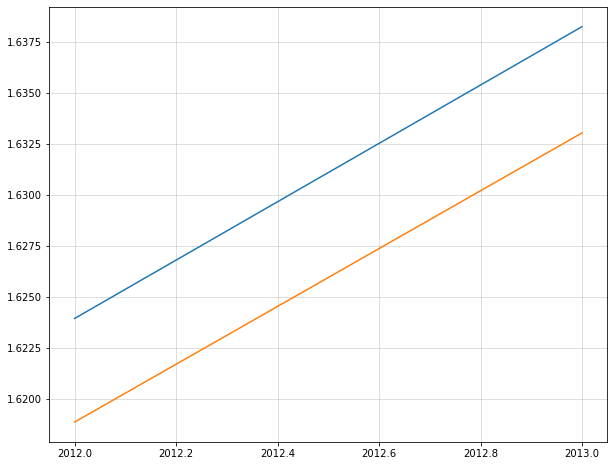

In [225]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(df_stat_pred['mean'])

ax.plot(df_stat_pred_sc1['mean'])

#ax.fill_between(dfb.index, dfb_levels['lower'], dfb_levels['upper'], color='k', alpha=0.1)

ax.grid(which='major', alpha=0.5);

## Questions

### Session 1

#### Question 2.5

We start by loading the data:

In [209]:
# We use skiprows=range(1, 2) to skip the first line in the CSV file (after the header) that contains info about the units
df_jam = pd.read_csv(
    "data/Module2_Caribbean_Assessment_File_Jamaica.csv", 
    skiprows=range(1,2), index_col=0, parse_dates=True)
df_bah = pd.read_csv(
    "data/Module2_Caribbean_Assessment_File_Bahamas.csv", 
    skiprows=range(1,2), index_col=0, parse_dates=True)

# Join two DataFrames
df = df_jam.join(df_bah).loc[:, ["jam_cpi_eop", "bah_cpi_eop"]]
df.head()

,jam_cpi_eop,bah_cpi_eop
1980-01-01,3.038,38.714
1981-01-01,3.183,42.193
1982-01-01,3.406,44.115
1983-01-01,3.974,45.653
1984-01-01,5.212,47.748


In [96]:
# Log-transform the variables and take the differences:
df = (df
 .assign(
     dljam_cpi=lambda x: np.log(x.jam_cpi_eop) - np.log(x.jam_cpi_eop.shift(1)),
     dlbah_cpi=lambda x: np.log(x.bah_cpi_eop) - np.log(x.bah_cpi_eop.shift(1)),
     )
 .dropna()
)
df.head()

,jam_cpi_eop,bah_cpi_eop,dljam_cpi,dlbah_cpi
1981-01-01,3.183,42.193,0.046625,0.086053
1982-01-01,3.406,44.115,0.067714,0.044546
1983-01-01,3.974,45.653,0.154235,0.034269
1984-01-01,5.212,47.748,0.271191,0.044868
1985-01-01,6.417,50.041,0.207987,0.046905


In [ ]:
# A more advanced usage of pandas (similar to dplyr's mutate ... across):
# df = (df
#  .pipe(lambda x: x.assign(**{f'l{col.name}': np.log(col) for col in [x.jam_cpi_eop, x.bah_cpi_eop]}))
#  .pipe(lambda x: x.assign(**{f'd{col.name}': col - col.shift(1) for col in [x.ljam_cpi_eop, x.lbah_cpi_eop]}))
# )

In [98]:
X = df["dljam_cpi"]
X = sm.add_constant(X)
y = df["dlbah_cpi"]
model = sm.OLS(y, X)
results = model.fit()
results.summary()

/home/joao/moocs/time-series/envs/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              dlbah_cpi   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     3.699
Date:                Thu, 14 Oct 2021   Prob (F-statistic):             0.0634
Time:                        12:42:48   Log-Likelihood:                 87.601
No. Observations:                  34   AIC:                            -171.2
Df Residuals:                      32   BIC:                            -168.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0217      0.005      3.972      0.000       0.011       0.033
dljam_cpi      0.0583      0.030      1.923      0.063      -0.003       0.120
==============================================================================
Omnibus:                       14.678   Durbin-Watson:                   0.614
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.630
Skew:                           1.368   Prob(JB):                     0.000404
Kurtosis:                       4.883   Cond. No.                         9.52
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Session 2

#### Question 2.6 

Which year did the inflation in Jamaica reach its highest value for the series?

Note that I'm taking advantage of the fact here that log-differences are approximately the same as percentage differences.

In [102]:
df.query('dljam_cpi == dljam_cpi.max()')

,jam_cpi_eop,bah_cpi_eop,dljam_cpi,dlbah_cpi
1991-01-01,22.906,69.456,0.588852,0.06213


To make sure that this is the correct answer, we can check the inflation rates in 2014 and 2006.

In [103]:
df.loc[["1991-01-01", "2014-01-01", "2006-01-01"], 'dljam_cpi']

1991-01-01    0.588852
2014-01-01    0.077885
2006-01-01    0.053476
Name: dljam_cpi, dtype: float64

#### Question 2.7

First, we need to load and clean the Atlantis data:

In [230]:
df = pd.read_csv("data/Module2_Caribbean_Assessment_File_Atlantis.csv", index_col=0, skiprows=range(1, 2), parse_dates=True)
df = df.loc[:, ["atl_infl", "atl_unemp_rate"]].dropna()
df.head()

,atl_infl,atl_unemp_rate
1991-01-01,5.551944,9.237
1992-01-01,4.311944,9.537
1993-01-01,3.738611,9.337
1994-01-01,9.065277,7.387
1995-01-01,6.511944,7.287


In [231]:
X = df.atl_unemp_rate
X = sm.add_constant(X)
y = df.atl_infl
model = sm.OLS(y, X)
results = model.fit()
results.params

/home/joao/moocs/time-series/envs/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


const             11.859023
atl_unemp_rate    -0.691685
dtype: float64

### Session 3

#### Question 2.9

Add lag of unemployment rate as another independent variable:

In [232]:
df = (
    df
    .assign(
        lag_infl=df.atl_infl.shift(1),
        lag_unemp=df.atl_unemp_rate.shift(1)
    )
    .dropna()
)

In [233]:
# Using R-style formulas
model = smf.ols("atl_infl ~ atl_unemp_rate + lag_unemp", data=df)
results = model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               atl_infl   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     6.720
Date:                Sun, 17 Oct 2021   Prob (F-statistic):            0.00586
Time:                        15:14:53   Log-Likelihood:                -41.569
No. Observations:                  23   AIC:                             89.14
Df Residuals:                      20   BIC:                             92.54
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         11.2305      1.883      5.963      0.000       7.302      15.159
atl_unemp_rate    -1.9563      0.548     -3.572      0.002      -3.099      -0.814
lag_unemp          1.3338      0.501      2.663      0.015       0.289       2.379
==============================================================================
Omnibus:                        0.252   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.882   Jarque-Bera (JB):                0.440
Skew:                           0.130   Prob(JB):                        0.803
Kurtosis:                       2.374   Cond. No.                         55.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Question 2.11

Note how Durbin-Watson statistic is < 1.95

In [234]:
# Using R-style formulas
model = smf.ols("atl_infl ~ atl_unemp_rate + lag_infl + lag_unemp", data=df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               atl_infl   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     4.314
Date:                Sun, 17 Oct 2021   Prob (F-statistic):             0.0176
Time:                        15:14:54   Log-Likelihood:                -41.505
No. Observations:                  23   AIC:                             91.01
Df Residuals:                      19   BIC:                             95.55
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         12.0103      3.080      3.899      0.001       5.563      18.458
atl_unemp_rate    -1.9709      0.562     -3.506      0.002      -3.148      -0.794
lag_infl          -0.0650      0.200     -0.324      0.749      -0.484       0.354
lag_unemp          1.3013      0.522      2.492      0.022       0.208       2.394
==============================================================================
Omnibus:                        0.194   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.907   Jarque-Bera (JB):                0.400
Skew:                           0.078   Prob(JB):                        0.819
Kurtosis:                       2.373   Cond. No.                         110.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Question 2.12

Formal Residual Test: Serial Correlation LM Test

In [235]:
# Import helper function defined in local module utils_statsmodels
from utils_statsmodels import bglm_test

bglm_test(results, 3)

Breusch-Godfrey LM Test: 
LM test statistic      3.525632
LM (Chi-sq) p-value    0.317453
F test statistic       0.965545
F p-value              0.433092
Null hypothesis: No Autocorrelation of any order up to 3 lags.
Fail to reject the null hypothesis at the .05 significance level
Data has no evidence of autocorrelation.


### Session 4

Atlantis: Out-of-Sample Forecast

Using our most recent specification of a Phillips Curve for Atlantis (the one that included unemployment, lagged unemployment, and the lagged dependent variable), let's assess the quality of the model by using it to generate a forecast for inflation for 2012-2014.

First, re-estimate your model using 1980-2012 data:

(Here it is weird because they use 2012 data to forecast 2012 inflation)

In [236]:
train = df.loc[:"2012-01-01"]
test = df.loc["2012-01-01":]

lm = smf.ols("atl_infl ~ atl_unemp_rate + lag_unemp + lag_infl", data=train).fit()
lm.params

Intercept         11.560128
atl_unemp_rate    -2.063151
lag_unemp          1.405890
lag_infl          -0.032165
dtype: float64

Next, make a dynamic forecast of Atlantic inflation for 3 years ('2012-'2014).

We'll use again the custom function `dynamic_pred()` to make the dynamic prediction. In real life, you never run a dynamic model via OLS...

In [237]:
df_pred = dynamic_pred(lm, test.drop(columns=['atl_infl']), 'lag_infl')
y_dyn_pred = df_pred['mean']
y_dyn_pred

2012-01-01    6.221351
2013-01-01    5.939721
2014-01-01    8.096808
Name: mean, dtype: float64

#### Question 2.16

What is the RMSE of the predictions?

In [238]:
from statsmodels.tools.eval_measures import rmse

rmse(test.atl_infl, y_dyn_pred)

1.2491965308780775

#### Question 2.17

In [239]:
pd.DataFrame(test.atl_infl).join(y_dyn_pred).rename(columns={"mean":"infl_pred"})

,atl_infl,infl_pred
2012-01-01,5.719287,6.221351
2013-01-01,7.893227,5.939721
2014-01-01,8.879893,8.096808


#### Question 2.18

Conduct the same forecasting experiment, except this time using a static method, and compare with the dynamic forecast:

In [240]:
static_predictions = lm.get_prediction(test.drop(columns=['atl_infl']))
y_stat_pred = static_predictions.predicted_mean
y_stat_pred

array([6.22135108, 5.95586967, 8.03397354])

In [241]:
pd.DataFrame({"observed": test.atl_infl.values,
             "static": y_stat_pred, 
             "dynamic": y_dyn_pred.values}).set_index(test.index)

,observed,static,dynamic
2012-01-01,5.719287,6.221351,6.221351
2013-01-01,7.893227,5.955870,5.939721
2014-01-01,8.879893,8.033974,8.096808


create an alternative forecasting scenario which assumes that unemployment in Atlantis is 1 percentage point higher during 2008-2011 than it actually was.

To do so, generate a new variable called "atl_unemp_rate_1" that reflects the 1 percentage point increase in unemployment during '08-'11.

In [252]:
df = (
    df
    .assign(atl_unemp_rate_1=lambda x: np.where(
        # Condition
        x.index.isin(['2008', '2009', '2010', '2011']),
        # If Condition is True
        x.atl_unemp_rate * 1.01,
        # Else
        x.atl_unemp_rate
    ))
)

df.tail()

,atl_infl,atl_unemp_rate,lag_infl,lag_unemp,atl_unemp_rate_1
2010-01-01,9.074082,5.001,6.360014,5.310,5.05101
2011-01-01,5.348331,5.783,9.074082,5.001,5.84083
2012-01-01,5.719287,6.445,5.348331,5.783,6.44500
2013-01-01,7.893227,7.019,5.719287,6.445,7.01900
2014-01-01,8.879893,6.369,7.893227,7.019,6.36900


In [253]:
train1 = df.loc[:"2012-01-01"]
test1 = df.loc["2012-01-01":]

lm1 = smf.ols("atl_infl ~ atl_unemp_rate_1 + lag_unemp + lag_infl", data=train1).fit()
df_pred1 = dynamic_pred(lm1, test1.drop(columns=['atl_infl']), 'lag_infl')
y_dyn_pred1 = df_pred1['mean']


pd.DataFrame({"observed": test.atl_infl.values,
             "dynamic": y_dyn_pred, 
             "dynamic scenario": y_dyn_pred1.values}).set_index(test.index)

,observed,dynamic,dynamic scenario
2012-01-01,5.719287,6.221351,6.250587
2013-01-01,7.893227,5.939721,5.956861
2014-01-01,8.879893,8.096808,8.114566
